<a href="https://colab.research.google.com/github/assermahmoud99/internship-tasks/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Downloading the Dataset from Kaggle

Here I used KaggleHub to automatically download the Amazon Product Reviews dataset.

*   The dataset comes with one single file contains the whole dataset.
*   stored it in path for loading it later with pandas.



In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("karkavelrajaj/amazon-sales-dataset",path='amazon.csv')

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'amazon-sales-dataset' dataset.
Path to dataset files: /kaggle/input/amazon-sales-dataset/amazon.csv


# 1. Instantiating the setup

In this section, All the required libraries got imported:

*   pandas for data handling.

*   scikit-learn for splitting data, vectorization, training Logistic Regression, and evaluation.

*   spaCy for advanced text preprocessing (lemmatization, stopword removal).
*   NLTK’s VADER sentiment analyzer for lexicon-based sentiment detection.


*   Loaded the dataset
*   Instantiated the sentiment analyser







In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download("vader_lexicon") #downloading sentiment analysis model
df = pd.read_csv(path) #extracting the data
sia = SentimentIntensityAnalyzer()


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# 2. Data sentiment

Here I created two sentiment labels:



1.   Rating-based (sentiment) → derived from star ratings (>3.5 = positive, <3.6 = negative).
2.   VADER-based (vader_sentiment) → generated from the review text using VADER (compound ≥ 0 = positive, else negative).

The main issue is that the dataset’s ratings are heavily skewed toward positive, making them unreliable for sentiment analysis. VADER helps by producing sentiment directly from the text, giving a more balanced variations within the data.




In [ ]:
df["review_text"] = df["review_title"].fillna("") + " " + df["review_content"].fillna("")
def vader_sentiment(text):
    score = sia.polarity_scores(str(text))["compound"]
    if score >= 0:
        return 1
    else:
        return 0

def sentiment_score(rating):
  if rating > 3.5:
    return 1
  elif rating < 3.6 :
    return 0
  else :
    return None
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df["vader_sentiment"] = df["review_content"].apply(vader_sentiment)
df['sentiment'] = df['rating'].apply(sentiment_score)
df = df.dropna(subset=['sentiment'])
df = df.dropna(subset=['vader_sentiment'])
print(df['sentiment'].value_counts())
print(df['vader_sentiment'].values)

sentiment
1.0    1396
0.0      68
Name: count, dtype: int64
[1 1 1 ... 1 0 1]


# 3. Text Cleaning with spaCy

I clean the reviews using spaCy:

*   Keep only alphabetic tokens.
*   Remove stopwords (e.g., the, is).

*   Lemmatize words (e.g., running → run).
*   Convert to lowercase.



This reduces noise and ensures the text is in a consistent form before vectorization.

In [ ]:

nlp = spacy.load('en_core_web_sm')
tokens = []
def clean_text(review):
  doc = nlp(review)
  tokens = [token.lemma_.lower() for token in doc if token.is_alpha and not token.is_stop]
  return " ".join(tokens)
df['review_text'] = df['review_text'].astype(str).apply(clean_text)
df['review_text'].head(10)


,review_text
0,satisfy charging fast value money product revi...
1,good braided cable type c device good quality ...
2,good speed early version good product work goo...
3,good product good nice nice product time chang...
4,good original decent good secondary use good q...
5,pretty good average quality good useful usb ca...
6,long durable charge lenovo tab best charge cab...
7,worth money suitable android auto good product...
8,work linux model antenna brand available less ...
9,good braided cable type c device good quality ...


# 4. Logistic Regression with Rating Labels
This trains a Logistic Regression classifier using rating-based sentiment labels as the target.

Reviews are converted into numerical features with TF-IDF.

The model is trained and evaluated with accuracy, confusion matrix, precision, recall, and F1.

Because the dataset is heavily skewed toward positive ratings, results reflect the imbalance problem.

In [ ]:
X = df['review_text']
y = df['sentiment']
X_train , X_test , y_train , y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
vecotrizer = TfidfVectorizer(stop_words='english')
X_train_vec = vecotrizer.fit_transform(X_train)
X_test_vec = vecotrizer.transform(X_test)
lr = LogisticRegression()
lr.fit(X_train_vec, y_train)
y_pred = lr.predict(X_test_vec)
print(lr.coef_)
print(confusion_matrix(y_test, y_pred))
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[-0.03166178 -0.10007559  0.00277746 ...  0.00288698  0.00288698
   0.00288698]]
[[  0  14]
 [  0 279]]
0.9522184300341296
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        14
         1.0       0.95      1.00      0.98       279

    accuracy                           0.95       293
   macro avg       0.48      0.50      0.49       293
weighted avg       0.91      0.95      0.93       293



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# 5. Logistic Regression with VADER Labels
This repeats the same pipeline, but with VADER-based sentiment labels as the target.

Again, reviews are vectorized with TF-IDF.

Logistic Regression is trained and evaluated in the same way.

This provides a fairer baseline because VADER assigns sentiment directly from text, helping reduce the effect of biased ratings.

In [ ]:
y_vader = df['vader_sentiment']
X_train_vader , X_test_vader , y_train_vader , y_test_vader = train_test_split(X, y_vader, test_size=0.2, random_state=42, stratify=y)
vecotrizer_vader = TfidfVectorizer(stop_words='english')
X_train_vec_vader = vecotrizer_vader.fit_transform(X_train_vader)
X_test_vec_vader = vecotrizer_vader.transform(X_test_vader)
lr_vader = LogisticRegression()
lr_vader.fit(X_train_vec_vader, y_train_vader)
y_pred_vader = lr_vader.predict(X_test_vec_vader)
print(lr_vader.coef_)
print(confusion_matrix(y_test_vader, y_pred_vader))
print(accuracy_score(y_test_vader, y_pred_vader))
print(classification_report(y_test_vader, y_pred_vader))

[[-0.0361344  -0.09363799  0.00233879 ...  0.00277802  0.00277802
   0.00277802]]
[[  0  17]
 [  0 276]]
0.9419795221843004
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.94      1.00      0.97       276

    accuracy                           0.94       293
   macro avg       0.47      0.50      0.49       293
weighted avg       0.89      0.94      0.91       293



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# 6. MultinomialNB training
Here I train a Multinomial Naive Bayes classifier using the rating-based labels.

It works well for text data represented as word counts or TF-IDF.

Results will be compared with Logistic Regression.

In [ ]:
from sklearn.naive_bayes import MultinomialNB

# Train Naive Bayes with rating-based labels
model_nb = MultinomialNB()
model_nb.fit(X_train_vec, y_train)
y_pred_nb = model_nb.predict(X_test_vec)
vader_nb = MultinomialNB()
vader_nb.fit(X_train_vec_vader, y_train)
y_pred_vader = vader_nb.predict(X_test_vec_vader)

print("Naive Bayes Confusion Matrix (Ratings):")
print(confusion_matrix(y_test, y_pred_nb))
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

print("Vader Naive Bayes Confusion Matrix (Ratings):")
print(confusion_matrix(y_test_vader, y_pred_vader))
print("Vader Naive Bayes Accuracy:", accuracy_score(y_test_vader, y_pred_vader))
print(classification_report(y_test_vader, y_pred_vader))


Naive Bayes Confusion Matrix (Ratings):
[[  0  14]
 [  0 279]]
Naive Bayes Accuracy: 0.9522184300341296
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        14
         1.0       0.95      1.00      0.98       279

    accuracy                           0.95       293
   macro avg       0.48      0.50      0.49       293
weighted avg       0.91      0.95      0.93       293

Vader Naive Bayes Confusion Matrix (Ratings):
[[  0  17]
 [  0 276]]
Vader Naive Bayes Accuracy: 0.9419795221843004
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.94      1.00      0.97       276

    accuracy                           0.94       293
   macro avg       0.47      0.50      0.49       293
weighted avg       0.89      0.94      0.91       293



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m

# 7. Extract Most Positive & Most Negative Words

Here we extract the top positive and negative words learned by Logistic Regression:


*  Words with large positive coefficients strongly indicate positive sentiment.

*  Words with large negative coefficients strongly indicate negative sentiment.



*   This shows not just the model’s accuracy, but also how it interprets the language in reviews.








Top Positive Words:
excellent 0.4410594946973644
picture 0.44606093707522027
installation 0.4499972622267269
easy 0.482998371916613
product 0.502055784697185
great 0.541760999239179
like 0.551485307203027
nice 0.7823982029308719
cable 1.3628110875502726
good 1.8454465808244804

Top Negative Words:
remote -1.8795748061166548
hair -1.022404133439489
heater -0.9275764148968302
slow -0.9171996902683053
waste -0.8511250670958519
break -0.8181216618282353
bad -0.6801395036559904
keyboard -0.6710756532981822
poor -0.6076663131527633
beginner -0.5903576003341032


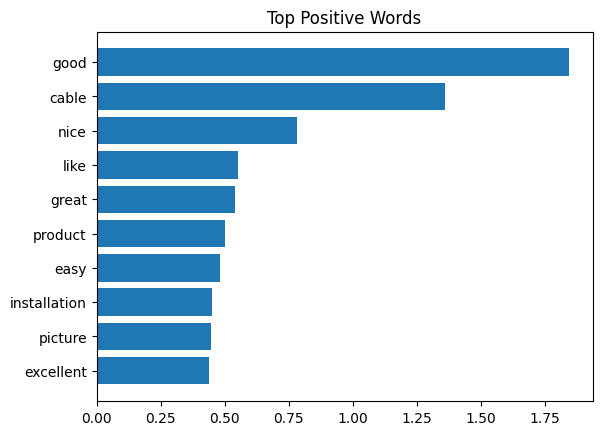

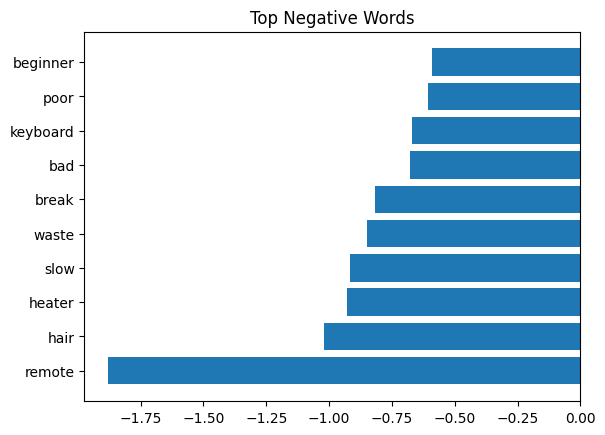

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

feature_names = vecotrizer.get_feature_names_out()
coeffs = lr.coef_[0]

# Top positive and negative words
top_pos_idx = np.argsort(coeffs)[-10:]
top_neg_idx = np.argsort(coeffs)[:10]

print("Top Positive Words:")
for i in top_pos_idx:
    print(feature_names[i], coeffs[i])

print("\nTop Negative Words:")
for i in top_neg_idx:
    print(feature_names[i], coeffs[i])

# Bar plots
plt.barh([feature_names[i] for i in top_pos_idx], coeffs[top_pos_idx])
plt.title("Top Positive Words")
plt.show()

plt.barh([feature_names[i] for i in top_neg_idx], coeffs[top_neg_idx])
plt.title("Top Negative Words")
plt.show()
